# Modules

In [56]:
%load_ext autoreload
%autoreload 2

import sys

import matplotlib.pyplot as plt
import pandas as pd
import torch
from sklearn import datasets
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.metrics import (ConfusionMatrixDisplay, classification_report,
                             confusion_matrix)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.optim import Adam
from torch.utils.data import DataLoader

sys.path.append("../")

from scarf.loss import NTXent
from scarf.model import Transformer#SCARF
from scarf.SSLNet import SSLNet
from scarf.Transformer import CNNTransformer

from example.dataset import ExampleDataset
from example.utils import dataset_embeddings, fix_seed, train_epoch

seed = 1234
fix_seed(seed)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Data

In [48]:
import pandas as pd

# Path to the CSV file
file_path = "/home/bilz/Datasets/CIOD/baselineIOD.csv"

# Load the CSV file into a DataFrame
df = pd.read_csv(file_path)

# Assuming the last column is the target column and the rest are feature columns
data = {
    'data': df.iloc[:, :-1],  # Select all columns except the last one as features
    'target': df.iloc[:, -1]   # Select the last column as target
}



In [49]:
#data = df  # datasets.load_breast_cancer(as_frame=True)
data, target = data["data"], data["target"]
train_data, test_data, train_target, test_target = train_test_split(
    data,
    target,
    test_size=0.2,
    stratify=target,
    random_state=seed
)

# preprocess
constant_cols = [c for c in train_data.columns if train_data[c].nunique() == 1]
train_data.drop(columns=constant_cols, inplace=True)
test_data.drop(columns=constant_cols, inplace=True)

scaler = StandardScaler()
train_data = pd.DataFrame(scaler.fit_transform(train_data), columns=train_data.columns)
test_data = pd.DataFrame(scaler.transform(test_data), columns=test_data.columns)

# to torch dataset
train_ds = ExampleDataset(
    train_data.to_numpy(),
    train_target.to_numpy(),
    columns=train_data.columns
)
test_ds = ExampleDataset(
    test_data.to_numpy(),
    test_data.to_numpy(),
    columns=test_data.columns
)

print(f"Train set: {train_ds.shape}")
print(f"Test set: {test_ds.shape}")
train_ds.to_dataframe().head()

Train set: (1178629, 9)
Test set: (294658, 9)


,RSRP,RSRQ,Light,Mag,Acc,Sound,Proximity,Daytime,New_Recording
0,0.305750,-2.076453,0.375198,3.129931,-0.535769,-0.667711,0.874993,2.040918,-0.007707
1,-0.644811,1.108672,-0.002607,0.946000,-0.538653,-1.438727,0.874993,2.040918,-0.007707
2,-0.090317,1.745697,-0.191510,-0.366778,-0.539022,0.538431,-1.142867,-0.489976,-0.007707
3,0.781030,0.790159,-0.191510,-0.315980,1.178698,0.364330,0.874993,-0.489976,-0.007707
4,0.939457,1.427184,-0.189456,0.336144,1.910575,0.448778,-1.142867,-0.489976,-0.007707


# Training

In [50]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'


In [60]:
batch_size = 64
epochs = 40
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)

model = SSLNet(
    input_dim=train_ds.shape[1],
    emb_dim=16,
    features_low=train_ds.features_low,
    features_high=train_ds.features_high,
    corruption_rate=0.6,
    dropout=0.1
).to(device)


optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
ntxent_loss = NTXent()

loss_history = []
print("Training is starting ...")
for epoch in range(1, epochs + 1):
    epoch_loss = train_epoch(model, ntxent_loss, train_loader, optimizer, device)
    loss_history.append(epoch_loss)

    #if epoch % 100 == 0:
    print(f"epoch {epoch}/{epochs} - loss: {loss_history[-1]:.4f}")


Training is starting ...


RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x144 and 9x16)

Text(0, 0.5, 'loss')

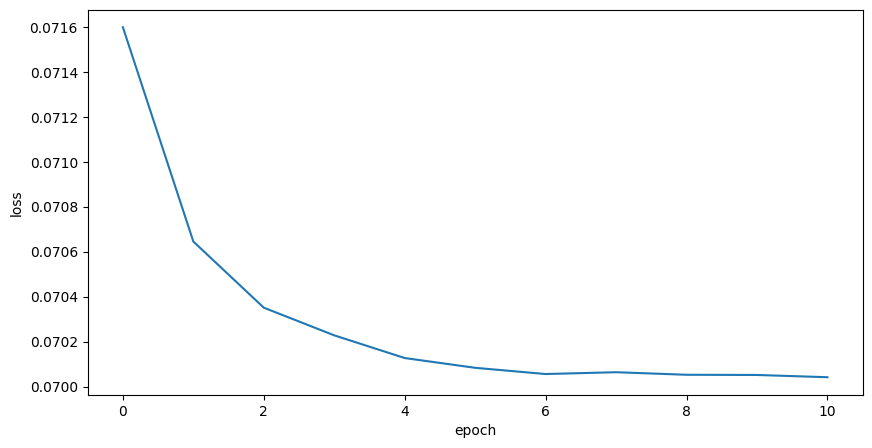

In [52]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(loss_history)
ax.set_xlabel("epoch")
ax.set_ylabel("loss")

# Evaluate embeddings

In [53]:
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

# get embeddings for training and test set
train_embeddings = dataset_embeddings(model, train_loader, device)
test_embeddings = dataset_embeddings(model, test_loader, device)

print(train_embeddings.shape)
print(test_embeddings.shape)

  0%|          | 0/18417 [00:00<?, ?it/s]

100%|██████████| 4605/4605 [00:06<00:00, 713.82it/s]

(1178629, 16)
(294658, 16)


              precision    recall  f1-score   support

         0.0       0.86      0.83      0.84    111874
         1.0       0.90      0.92      0.91    182784

    accuracy                           0.88    294658
   macro avg       0.88      0.87      0.88    294658
weighted avg       0.88      0.88      0.88    294658



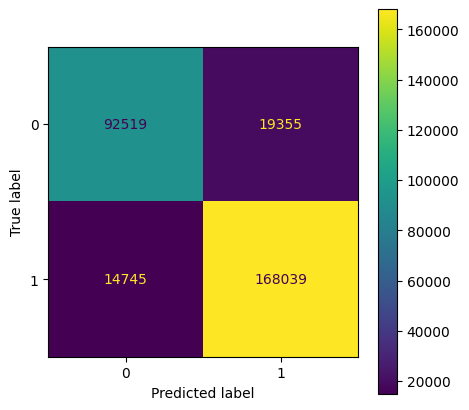

In [54]:
clf = LogisticRegression()

# vanilla dataset: train the classifier on the original data
clf.fit(train_data, train_target)
vanilla_predictions = clf.predict(test_data)

print(classification_report(test_target, vanilla_predictions))
cm = confusion_matrix(test_target, vanilla_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(ax=ax)

              precision    recall  f1-score   support

         0.0       0.70      0.63      0.67    111874
         1.0       0.79      0.84      0.81    182784

    accuracy                           0.76    294658
   macro avg       0.74      0.73      0.74    294658
weighted avg       0.76      0.76      0.76    294658



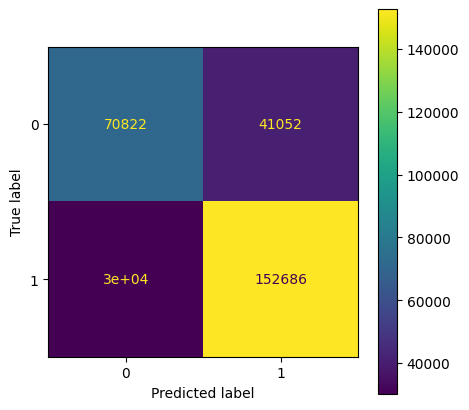

In [55]:
# embeddings dataset: train the classifier on the embeddings
clf.fit(train_embeddings, train_target)
vanilla_predictions = clf.predict(test_embeddings)

print(classification_report(test_target, vanilla_predictions))
cm = confusion_matrix(test_target, vanilla_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(ax=ax)

# Visualzie using t-sne 

In [ ]:
tsne = TSNE(n_components=2)
reduced = tsne.fit_transform(train_embeddings)
positive = train_target == 1

fig, ax = plt.subplots(figsize=(5, 5))

ax.scatter(reduced[positive, 0], reduced[positive, 1], label="positive")
ax.scatter(reduced[~positive, 0], reduced[~positive, 1], label="negative")
plt.legend()

KeyboardInterrupt: 